In [1]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import plotly.express as px
from scipy import stats
import optuna
import pickle

import warnings
warnings.filterwarnings('ignore')

c:\IDE\skillfactory_ML_course\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

## Часть 1. Загрузка подготовленного датасета. ##

In [3]:
df = pd.read_pickle('data/df_for_model_3.pickle')
df.head(3)

,status,propertyType,street,baths,fireplace,sqft,beds,stories,target,private_pool,...,cooling,lot_size,school_rate_mean,school_distance_mean,has_parking,garage,parking_spaces,log_target,states_shoted,cities_shorted
1,for sale,single,avenue,3,0,1947.0,3,2,310000.0,0,...,0,5828.0,2.666667,1.326667,0,0,0,12.644331,WA,others
2,for sale,single,road,2,1,3000.0,3,1,2895000.0,1,...,1,8626.0,6.666667,1.960000,1,1,0,14.878496,CA,los angeles
3,for sale,single,avenue,8,1,6457.0,5,3,2395000.0,0,...,1,8220.0,9.250000,0.752500,1,1,0,14.688894,TX,dallas


In [4]:
''' Подготовим список категориальных признаков и числовых признаков'''
str_col = ['status','propertyType','street','heating','states_shoted','cities_shorted']
num_col = ['baths',
 'fireplace',
 'sqft',
 'beds',
 'stories',
 'private_pool',
 'year_built',
 'cooling',
 'lot_size',
 'school_rate_mean',
 'school_distance_mean',
 'has_parking',
 'garage',
 'parking_spaces']


In [5]:
df = df.drop(['log_target'], axis=1)

## Часть 2. Выбор модели регрессии. ##

In [6]:
''' Создание копии исходного датасета, кодирование категориальных признаков'''
dft = df.copy()
print(f'Размер датасета до кодирования категориальных признаков {dft.shape}')
dft = pd.concat([dft, pd.get_dummies(dft[str_col])], axis=1)
dft = dft.drop(['status','propertyType','street','heating','states_shoted','cities_shorted',], axis=1)
print(f'Размер датасета {dft.shape}')

Размер датасета до кодирования категориальных признаков (348298, 21)
Размер датасета (348298, 194)


In [7]:
'''Разделение данных на тестовую и тренировочную выборки'''
X = dft.drop(['target'], axis=1)
y = dft['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
'''Предподготовка данных'''
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

In [9]:
table_dict = dict()
table_columns = ['Train', 'Test']

base_line linear regression

In [22]:
# за отправную точку возьмем линейную регрессию
lin_regr = LinearRegression()
lin_regr.fit(X_train, y_train)
y_train_pred = lin_regr.predict(X_train_scaled)
y_test_pred = lin_regr.predict(X_test_scaled)

# print('RMSE on the train sample: {:.2f}'.format(
#     np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))))
# print('RMSE on the validation sample: {:.2f}'.format(
#     np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))))

print('Train RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

Train RMSE: 368927.95467205165
Test RMSE: 371023.02902920434


In [23]:
table_dict['Linear regression (r12n)'] = [
    mean_squared_error(y_train, y_train_pred, squared=False),
    mean_squared_error(y_test, y_test_pred, squared=False)
]

модель randomforestregressor

In [24]:
rf_best_params = {'criterion': 'squared_error', 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 100}
randfor = RandomForestRegressor(random_state=42, **rf_best_params)
randfor.fit(X_train_scaled, y_train)
y_train_pred = randfor.predict(X_train_scaled)
y_test_pred  = randfor.predict(X_test_scaled)
print('Train RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

Train RMSE: 357009.65183225577
Test RMSE: 363979.78188651847


In [25]:
table_dict['Random Forest'] = [
    mean_squared_error(y_train, y_train_pred, squared=False),
    mean_squared_error(y_test, y_test_pred, squared=False)
]

модель xgbregressor

In [26]:
xgb = XGBRegressor(seed=42)
xgb.fit(X_train_scaled, y_train)
y_train_pred = xgb.predict(X_train_scaled)
y_test_pred  = xgb.predict(X_test_scaled)
print('Train RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

Train RMSE: 259990.7813460986
Test RMSE: 280517.7563035519


In [27]:
table_dict['XGBoost'] = [
    mean_squared_error(y_train, y_train_pred, squared=False),
    mean_squared_error(y_test, y_test_pred, squared=False)
]

In [29]:
'''Наилутший результат показала модель регрессии с дефолтными настройками XGBoost'''
final_table = pd.DataFrame.from_dict(data=table_dict, orient='index', columns=table_columns)
final_table.round()

,Train,Test
Linear regression (r12n),368928.0,371023.0
Random Forest,357010.0,363980.0
XGBoost,259991.0,280518.0


## Часть 3. Модель XGBoost. ##

In [10]:
''' Постараемся подобрать оптимальные гиперпараметры модели XGBoost показавшей
наилучшие результаты с использованием Optuna'''
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0)
        
    }
    model = XGBRegressor(seed = 42, **param)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return mean_squared_error(y_test, y_pred, squared=False)

In [11]:
# Create the study
optuna.visualization.is_available()
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=5)

[I 2023-12-06 21:55:52,285] A new study created in memory with name: regression
[I 2023-12-06 21:56:34,333] Trial 0 finished with value: 331225.6830055093 and parameters: {'max_depth': 9, 'learning_rate': 0.01574221120942059, 'n_estimators': 441, 'min_child_weight': 10, 'gamma': 0.6707209451069464, 'subsample': 0.8881213139866544, 'colsample_bytree': 0.12413226262191117, 'reg_alpha': 0.16822080582595858, 'reg_lambda': 0.5458268558886962}. Best is trial 0 with value: 331225.6830055093.
[I 2023-12-06 22:01:37,519] Trial 1 finished with value: 258969.91937812365 and parameters: {'max_depth': 10, 'learning_rate': 0.01650161066734016, 'n_estimators': 927, 'min_child_weight': 9, 'gamma': 0.4821188404382099, 'subsample': 0.9135612177628304, 'colsample_bytree': 0.808163137991467, 'reg_alpha': 0.4006455008122476, 'reg_lambda': 0.25961109573442}. Best is trial 1 with value: 258969.91937812365.
[I 2023-12-06 22:03:41,940] Trial 2 finished with value: 312603.81443005183 and parameters: {'max_depth

In [12]:
study.optimize(objective, n_trials=35)

[I 2023-12-06 22:10:35,985] Trial 5 finished with value: 399628.84937239095 and parameters: {'max_depth': 5, 'learning_rate': 0.791429223876852, 'n_estimators': 764, 'min_child_weight': 6, 'gamma': 0.8834571201068376, 'subsample': 0.27958846201567117, 'colsample_bytree': 0.9053686538258173, 'reg_alpha': 0.6398487207117788, 'reg_lambda': 0.5447957990517379}. Best is trial 1 with value: 258969.91937812365.
[I 2023-12-06 22:11:32,567] Trial 6 finished with value: 277062.0359064567 and parameters: {'max_depth': 7, 'learning_rate': 0.4540710238450949, 'n_estimators': 495, 'min_child_weight': 6, 'gamma': 0.5499696444738131, 'subsample': 0.511485010167603, 'colsample_bytree': 0.22183262404845858, 'reg_alpha': 0.7265131614425244, 'reg_lambda': 0.16385868774324178}. Best is trial 1 with value: 258969.91937812365.
[I 2023-12-06 22:12:15,614] Trial 7 finished with value: 311042.58201601397 and parameters: {'max_depth': 10, 'learning_rate': 0.8973074811535617, 'n_estimators': 127, 'min_child_weigh

In [13]:
# Print the best parameters
print('Best parameters', study.best_params)
# Print the best value
print('Best value', study.best_value)

Best parameters {'max_depth': 10, 'learning_rate': 0.15731514140750152, 'n_estimators': 884, 'min_child_weight': 2, 'gamma': 0.4786406006113764, 'subsample': 0.9370506411504153, 'colsample_bytree': 0.6588413851034691, 'reg_alpha': 0.42809669399162953, 'reg_lambda': 0.2730450833215283}
Best value 237617.4457350021


In [14]:
optuna.visualization.plot_optimization_history(study, target_name="rmse")

In [15]:
optuna.visualization.plot_param_importances(study, target_name="rmse")

In [16]:
optuna.visualization.plot_contour(study, params=["max_depth", "learning_rate"],
                                  target_name="rsme")

In [31]:
best_params_ = {'max_depth': 10, 'learning_rate': 0.27709654408982404, 'n_estimators': 665, 'min_child_weight': 5, 'gamma': 0.7761973587710317, 'subsample': 0.7887000601591988, 'colsample_bytree': 0.4221933346229272, 'reg_alpha': 0.342970136714684, 'reg_lambda': 0.8236712370675622}

In [32]:
xgb = XGBRegressor(**best_params_, seed=42)
xgb.fit(X_train_scaled, y_train)
y_train_pred = xgb.predict(X_train_scaled)
y_test_pred  = xgb.predict(X_test_scaled)
print('Train RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

Train RMSE: 130805.94783239845
Test RMSE: 249211.6072599088


In [36]:
''' Мы можем утверждать, что модель уловила около 76% закономерности в данных,
а абсолютная медианная ошибка в предсказании стоимости недвижимости составляет
65 тыс. долларов'''

print('Train RMSE:', r2_score(y_train, y_train_pred))
print('Test RMSE:', r2_score(y_test, y_test_pred))

print('MeAE on the validation sample: {:.1f} долларов'.format(
    metrics.median_absolute_error(y_test, y_test_pred)))

Train RMSE: 0.9356075837435911
Test RMSE: 0.7697481573940677
MeAE on the validation sample: 65739.5 долларов


## Часть 4. Создание pipeline. ##

In [7]:
''' Создание копии исходного датасета, кодирование категориальных признаков'''
dft = df.copy()

In [9]:
best_params_ = {'max_depth': 10, 'learning_rate': 0.27709654408982404, 'n_estimators': 665, 'min_child_weight': 5, 'gamma': 0.7761973587710317, 'subsample': 0.7887000601591988, 'colsample_bytree': 0.4221933346229272, 'reg_alpha': 0.342970136714684, 'reg_lambda': 0.8236712370675622}

In [8]:
preprocessor = make_column_transformer(
    (StandardScaler(), num_col),
    (OneHotEncoder(handle_unknown="ignore", drop="first"), str_col))

In [10]:
clf = make_pipeline(preprocessor, XGBRegressor(**best_params_,seed=42))

In [11]:
X = dft.drop('target', axis=1)
y = dft['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
clf.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['baths', 'fireplace', 'sqft',
                                                   'beds', 'stories',
                                                   'private_pool', 'year_built',
                                                   'cooling', 'lot_size',
                                                   'school_rate_mean',
                                                   'school_distance_mean',
                                                   'has_parking', 'garage',
                                                   'parking_spaces']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore')...
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.27709654408982404, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=10,
                              max_leaves=None, min_child_weight=5, missing=nan,
                              monotone_constraints=None, n_estimators=665,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [13]:
y_train_pred = clf.predict(X_train)
y_test_pred  = clf.predict(X_test)
print('Train RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

Train RMSE: 133110.3421801776
Test RMSE: 249028.9777160837


In [14]:
print('Train RMSE:', r2_score(y_train, y_train_pred))
print('Test RMSE:', r2_score(y_test, y_test_pred))

Train RMSE: 0.9333188106650816
Test RMSE: 0.7700855042890946


In [15]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
import numpy as np

best_params = best_params_
rmse_train = []
rmse_test = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    rmse_train.append(mean_squared_error(y_train, y_train_pred, squared=False))
    rmse_test.append(mean_squared_error(y_test, y_test_pred, squared=False))
rmse_train = np.array(rmse_train)
rmse_test = np.array(rmse_test)
print("mean rmse is: {}".format(rmse_train.mean()))
print("mean rmse is: {}".format(rmse_test.mean()))

mean rmse is: 131882.0213922286
mean rmse is: 246571.01713874043


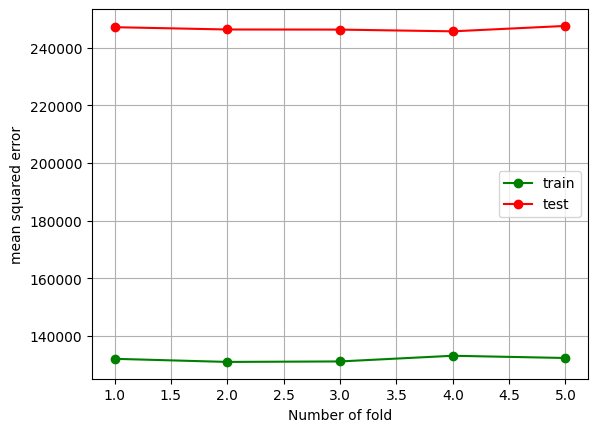

In [16]:
folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, rmse_train, 'o-', color='green', label='train')
plt.plot(folds, rmse_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('mean squared error')
plt.show()

## Часть 5. Финальная подготовка модели. ##

In [20]:
import joblib
import json

In [18]:
path_model = "models/model2.sav"
path_unique_values = "data/unique_values2.json"

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 348298 entries, 1 to 376608
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                348298 non-null  object 
 1   propertyType          348298 non-null  object 
 2   street                348298 non-null  object 
 3   baths                 348298 non-null  int32  
 4   fireplace             348298 non-null  int32  
 5   sqft                  348298 non-null  float64
 6   beds                  348298 non-null  int32  
 7   stories               348298 non-null  int32  
 8   private_pool          348298 non-null  int64  
 9   year_built            348298 non-null  int32  
 10  heating               348298 non-null  object 
 11  cooling               348298 non-null  int32  
 12  lot_size              348298 non-null  float64
 13  school_rate_mean      348298 non-null  float64
 14  school_distance_mean  348298 non-null  float64
 15  has_p

In [ ]:
#Saving the model
joblib.dump(clf, path_model)

#save unique values
dict_unique = {key: X[key].unique().tolist() for key in X.columns}
with open(path_unique_values, 'w') as file:
    json.dump(dict_unique, file)

In [38]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = XGBRegressor(**param)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return mean_squared_error(y_test, y_pred, squared=False)


In [39]:
# Create the study
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=10)


[I 2023-11-27 18:14:49,492] A new study created in memory with name: regression
[I 2023-11-27 18:14:56,871] Trial 0 finished with value: 398445.9956703492 and parameters: {'max_depth': 1, 'learning_rate': 0.41753849123143616, 'n_estimators': 105, 'min_child_weight': 7, 'gamma': 0.7396079174152242, 'subsample': 0.2671811582443633, 'colsample_bytree': 0.8491262030781767, 'reg_alpha': 0.5143726253932969, 'reg_lambda': 0.461045285970103, 'random_state': 977}. Best is trial 0 with value: 398445.9956703492.
[I 2023-11-27 18:17:33,355] Trial 1 finished with value: 1017494.6196596569 and parameters: {'max_depth': 9, 'learning_rate': 0.6078608834820108, 'n_estimators': 886, 'min_child_weight': 6, 'gamma': 0.3529235169312115, 'subsample': 0.16339745818124207, 'colsample_bytree': 0.43604602363088185, 'reg_alpha': 0.02368542665831514, 'reg_lambda': 0.9207731010581247, 'random_state': 126}. Best is trial 0 with value: 398445.9956703492.
[I 2023-11-27 18:18:50,403] Trial 2 finished with value: 31160

In [40]:
# Print the best parameters
print('Best parameters', study.best_params)


Best parameters {'max_depth': 8, 'learning_rate': 0.5857603430263628, 'n_estimators': 712, 'min_child_weight': 10, 'gamma': 0.8608770141069374, 'subsample': 0.8914373690290588, 'colsample_bytree': 0.8022520819057581, 'reg_alpha': 0.8200382160134515, 'reg_lambda': 0.882237576161878, 'random_state': 178}


In [41]:
# Print the best value
print('Best value', study.best_value)


Best value 301441.8453243442


In [42]:
model = XGBRegressor(**study.best_params)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))


MSE:  90867186112.54582
RMSE:  301441.8453243442


In [ ]:
filename = "data/xgbregressor.pickle"
pickle.dump(model, open(filename, "wb"))


In [44]:
# print('Train RMSE:', r2_score(y_train, y_train_pred))
print('Test RMSE:', r2_score(y_test, y_pred))

Test RMSE: 0.7258033230380283


In [ ]:
# def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
#     """_summary_

#     the Root Mean Squared Log Error (RMSLE) metric
#     """
#     return np.sqrt(mean_squared_log_error(y_true,y_pred))

In [ ]:
# # target function

# def objective(trial, X, y):
#     param_grid = {
#         "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "num_leaves": trial.suggest_int("num_leaves", 20, 300, step=50),
#         "max_depth": trial.suggest_int("max_depth", 3, 10, step=2),
#         "min_child_samples":trial.suggest_int("min_child_samples", 5, 200, step=50)
#     }
    
#     cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
#     cv_predicts = np.empty(5)
#     for idx, (train_idx, test_idx) in enumerate(cv.split(X,y)):
#         X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#         y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
#         pruning_callback = optuna.integration.LightGBMPruningCallback(
#             trial, "l2")
#         model = XGBRegressor(**param_grid)
#         model.fit(X_train_scaled,
#                   y_train,
#                   eval_set = [(X_test_scaled, y_test)],
#                   eval_metric="rmse",
#                   callbacks=[pruning_callback]
#                 #   verbose = -1
#                   # early_stopping_rounds = 100
#                   )
#     preds = model.predict(X_test)
#     cv_predicts[idx] = rmsle(y_test, preds)
    
#     return np.mean(cv_predicts)      
        
        

In [ ]:
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }

In [21]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 50, 500, 50)
  max_depth = trial.suggest_int('max_depth', 1, 30, 1)
  min_child_weight = trial.suggest_int('min_child_weight', 1, 10, 1)

  # создаем модель
  model = XGBRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_child_weight=min_child_weight,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [22]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="XGboostry", direction="minimize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

[I 2023-11-27 22:21:34,989] A new study created in memory with name: XGboostry
[W 2023-11-27 22:23:35,017] Trial 0 failed with parameters: {'n_estimators': 450, 'max_depth': 10, 'min_child_weight': 8} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\IDE\Skillfactory\.venv\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\John Lee\AppData\Local\Temp\ipykernel_24444\743921878.py", line 13, in optuna_rf
    model.fit(X_train_scaled, y_train)
  File "c:\IDE\Skillfactory\.venv\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\IDE\Skillfactory\.venv\lib\site-packages\xgboost\sklearn.py", line 1025, in fit
    self._Booster = train(
  File "c:\IDE\Skillfactory\.venv\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\IDE\Skillfactory\.venv\lib\site-packages\xgboost\training.py", line 185, 

KeyboardInterrupt: 